<a href="https://colab.research.google.com/github/albim72/--MLDL_KRK--/blob/main/klasyfikacja_tekstu_filmy_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 14s 0us/step


In [ ]:
os.listdir(dataset_dir)

['test', 'imdbEr.txt', 'README', 'train', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'unsup',
 'urls_unsup.txt',
 'urls_neg.txt']

In [ ]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [ ]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f'recenzja: {text_batch.numpy()[i]}')
    print(f'etykieta: {label_batch.numpy()[i]}')

recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
etykieta: 0
recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
print(f"Etykieta 0 -> {raw_train_ds.class_names[0]}")
print(f"Etykieta 1 -> {raw_train_ds.class_names[1]}")


Etykieta 0 -> neg
Etykieta 1 -> pos


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')


In [ ]:
#wektoryzacja tekstu
max_features = 10_000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [ ]:
train_text = raw_test_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorized_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [ ]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0],label_batch[0]
print(f'Recenzja: {first_review}')
print(f'Etykieta: {first_label}')
print(f'widok zwektoryzowany: {vectorized_text(first_review,first_label)}')


Recenzja: b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Etykieta: 1
widok zwektoryzowany: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 260,  105,   87,    5,    1,    1,   93,   10,   67,  127,   12,
          11,    7,   24,  117,   19,    6, 1324,    4,    2,   87, 1795,
          29,    3, 2251, 2491,  823,  409,    1,  372,    5,    1, 1810,
        1673,  116,    2, 1336,    5,   33, 2496,    1,  37

In [ ]:
print(f"716 --> {vectorize_layer.get_vocabulary()[716]}")
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")
print(f"2 --> {vectorize_layer.get_vocabulary()[2]}")
print(f"rozmiar słownika: {len(vectorize_layer.get_vocabulary())}")

716 --> havent
1287 --> boyfriend
313 --> shot
2 --> the
rozmiar słownika: 10000


In [ ]:
train_ds = raw_train_ds.map(vectorized_text)
val_ds = raw_val_ds.map(vectorized_text)
test_ds = raw_test_ds.map(vectorized_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#TWORZENIE MODELU

embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.6626 - binary_accuracy: 0.6914 - val_loss: 0.6133 - val_binary_accuracy: 0.7664
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5490 - binary_accuracy: 0.7944 - val_loss: 0.5012 - val_binary_accuracy: 0.8176
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4480 - binary_accuracy: 0.8407 - val_loss: 0.4243 - val_binary_accuracy: 0.8438
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3820 - binary_accuracy: 0.8629 - val_loss: 0.3783 - val_binary_accuracy: 0.8566
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3402 - binary_accuracy: 0.8766 - val_loss: 0.3495 - val_binary_accuracy: 0.8658
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3105 - binary_accuracy: 0.8860 - val_loss: 0.3305 - val_binary_accuracy: 0.8690
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [ ]:
loss,accuracy = model.evaluate(test_ds)

782/782 [==============================] - 10s 12ms/step - loss: 0.3088 - binary_accuracy: 0.8749


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

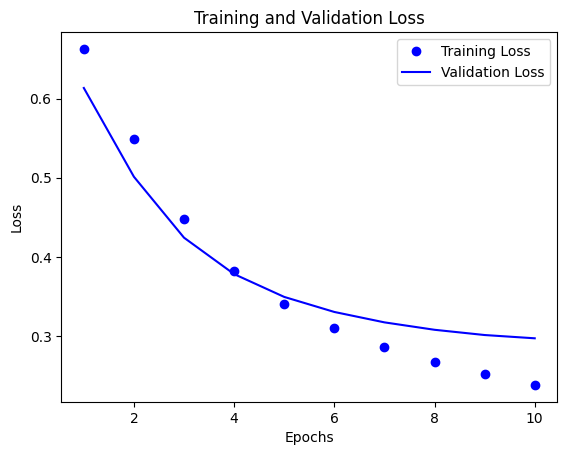

In [ ]:
acc= history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),optimizer='adam',metrics=['accuracy']
)

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3088 - accuracy: 0.8749
0.8749200105667114


In [ ]:
teksty = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible",
    "Vary bad movie!",
    "Big shit",
    "Disaster",
    "Beautiful disaster",
    "Głupi film"
]

In [ ]:
export_model.predict(teksty)

1/1 [==============================] - 0s 221ms/step


array([[0.62168443],
       [0.44304112],
       [0.36192587],
       [0.3641728 ],
       [0.53049886],
       [0.46154758],
       [0.5543959 ],
       [0.52718645]], dtype=float32)